In [80]:
from time import time

import matplotlib.pyplot as plt
from scipy.stats import loguniform

from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [81]:
lfw_people = fetch_lfw_people(data_home="../data", min_faces_per_person=50, resize=0.96, download_if_missing=False)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

print(f"image shape: {w}, {h}")

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
print(X[0])
print(X.shape)
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

image shape: 90, 120
[0.29934642 0.31895426 0.33202615 ... 0.61045754 0.530719   0.41960785]
(1560, 10800)
Total dataset size:
n_samples: 1560
n_features: 10800
n_classes: 12


In [82]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [83]:
n_components = 150

print(
    "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
)
t0 = time()
pca = PCA(n_components=n_components, svd_solver="auto", whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 1170 faces
done in 0.456s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.050s


In [84]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 6.891s
Best estimator found by grid search:
SVC(C=10869.614103027174, class_weight='balanced', gamma=0.001547099074026646)


Predicting people's names on the test set
done in 0.067s
                   precision    recall  f1-score   support

     Ariel Sharon       0.80      0.75      0.77        16
     Colin Powell       0.82      0.89      0.86        66
  Donald Rumsfeld       0.58      0.70      0.63        27
    George W Bush       0.87      0.84      0.85       140
Gerhard Schroeder       0.64      0.75      0.69        24
      Hugo Chavez       0.92      0.65      0.76        17
   Jacques Chirac       0.71      0.50      0.59        10
    Jean Chretien       0.85      0.79      0.81        14
    John Ashcroft       1.00      0.81      0.90        16
Junichiro Koizumi       0.90      0.82      0.86        11
  Serena Williams       0.78      0.78      0.78         9
       Tony Blair       0.79      0.85      0.82        40

         accuracy                           0.81       390
        macro avg       0.80      0.76      0.78       390
     weighted avg       0.82      0.81      0.81       3

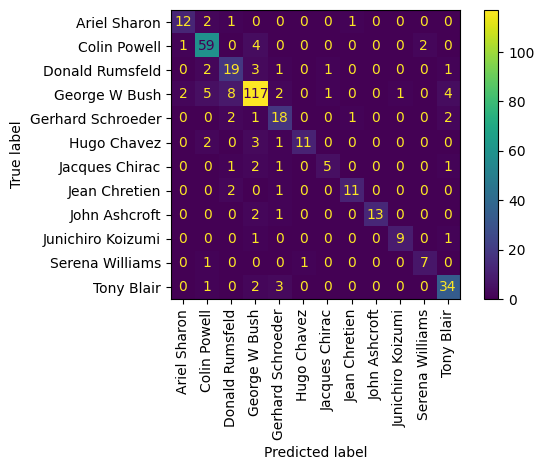

In [85]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

In [86]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

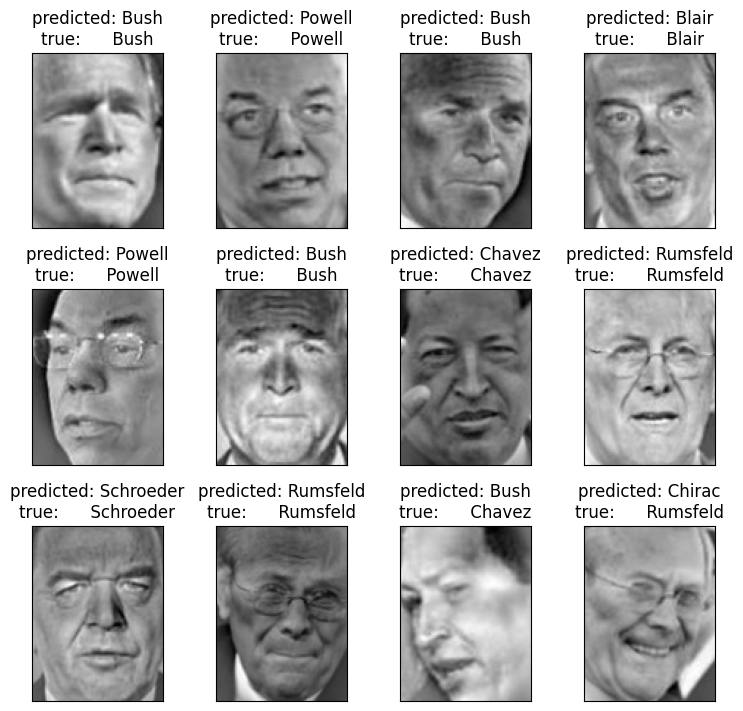

In [87]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)


prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)

In [88]:
eigenfaces[0]

array([[-0.00203218, -0.0022987 , -0.00254166, ..., -0.00370258,
        -0.00355157, -0.00330374],
       [-0.00220205, -0.00244558, -0.00266679, ..., -0.00389336,
        -0.00377091, -0.00358411],
       [-0.00245426, -0.00269138, -0.00290325, ..., -0.00409026,
        -0.00399291, -0.00381003],
       ...,
       [-0.00084766, -0.00096212, -0.0010838 , ..., -0.0017742 ,
        -0.00168   , -0.00160737],
       [-0.00084777, -0.00097662, -0.00104078, ..., -0.00181773,
        -0.00168994, -0.00156507],
       [-0.0007976 , -0.00091465, -0.00093525, ..., -0.00186533,
        -0.00169654, -0.00154981]], dtype=float32)

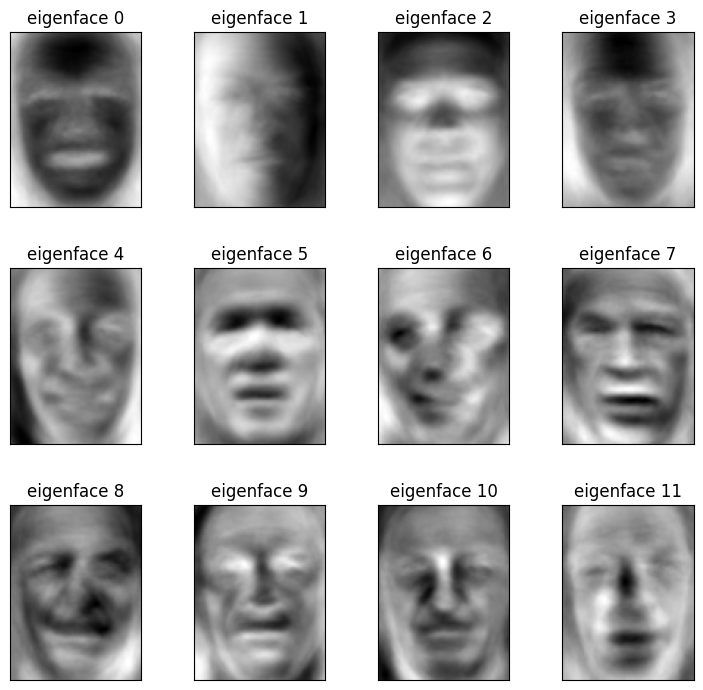

In [89]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()